[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


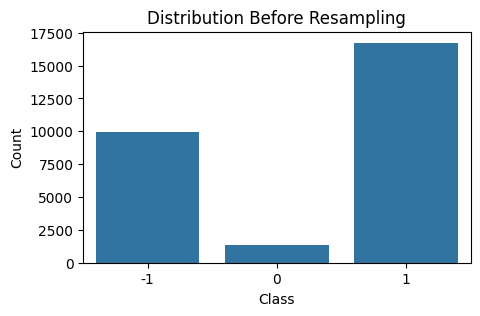

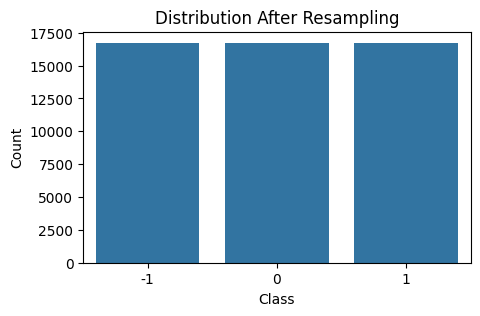

Running model: Logistic Regression
Accuracy: 0.7179956717163309
Classification Report:
              precision    recall  f1-score   support

          -1       0.81      0.77      0.79      4260
           0       0.10      0.42      0.17       578
           1       0.91      0.71      0.80      7176

    accuracy                           0.72     12014
   macro avg       0.61      0.63      0.58     12014
weighted avg       0.83      0.72      0.76     12014

Best Parameters: {'classifier__C': 1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 1)}


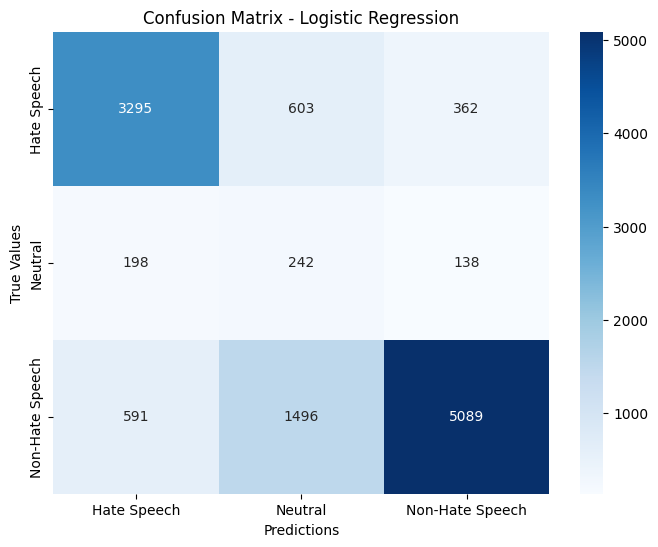


Running model: Decision Tree
Accuracy: 0.7373064757782587
Classification Report:
              precision    recall  f1-score   support

          -1       0.73      0.66      0.70      4260
           0       0.12      0.18      0.15       578
           1       0.81      0.83      0.82      7176

    accuracy                           0.74     12014
   macro avg       0.56      0.56      0.55     12014
weighted avg       0.75      0.74      0.74     12014

Best Parameters: {'classifier__max_depth': None, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}


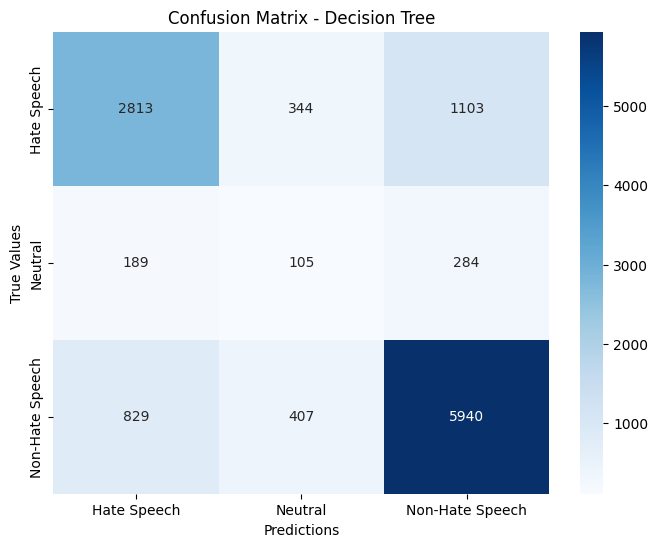


Running model: KNN
Accuracy: 0.4926752122523722
Classification Report:
              precision    recall  f1-score   support

          -1       0.53      0.52      0.52      4260
           0       0.08      0.56      0.14       578
           1       0.91      0.47      0.62      7176

    accuracy                           0.49     12014
   macro avg       0.51      0.52      0.43     12014
weighted avg       0.73      0.49      0.56     12014

Best Parameters: {'classifier__n_neighbors': 3, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}


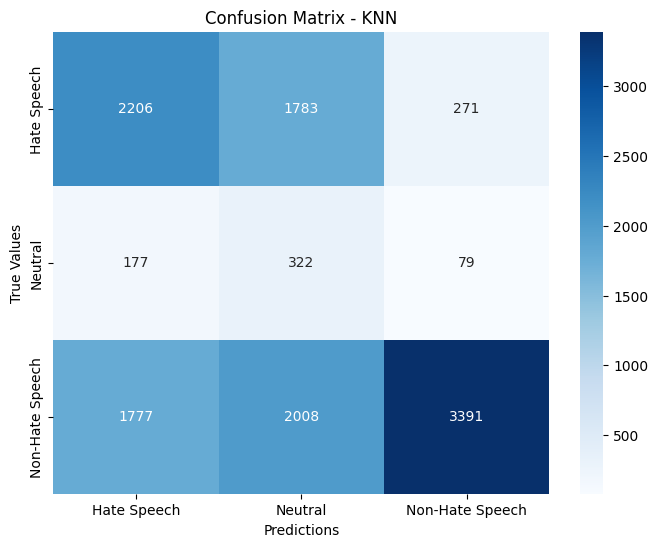


Running model: Random Forest


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Accuracy: 0.774846012984851
Classification Report:
              precision    recall  f1-score   support

          -1       0.76      0.75      0.75      4260
           0       0.12      0.15      0.14       578
           1       0.85      0.84      0.85      7176

    accuracy                           0.77     12014
   macro avg       0.58      0.58      0.58     12014
weighted avg       0.78      0.77      0.78     12014

Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 100, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 1)}


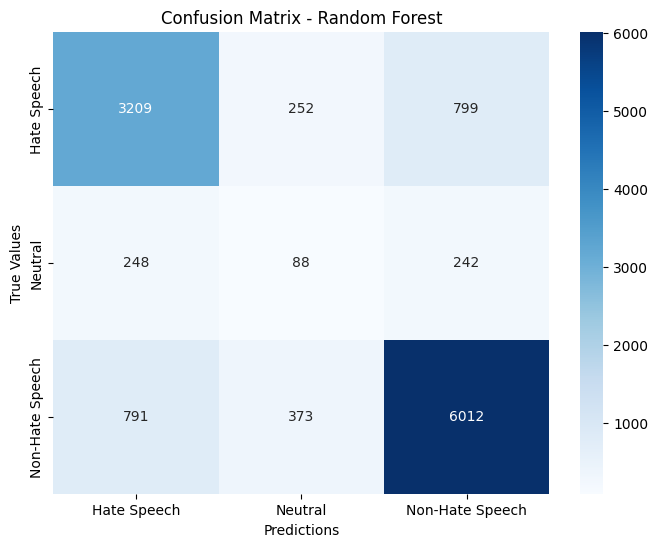


Running model: SVM
Accuracy: 0.6943565839853504
Classification Report:
              precision    recall  f1-score   support

          -1       0.79      0.76      0.78      4260
           0       0.09      0.41      0.15       578
           1       0.91      0.68      0.78      7176

    accuracy                           0.69     12014
   macro avg       0.60      0.62      0.57     12014
weighted avg       0.83      0.69      0.75     12014

Best Parameters: {'classifier__C': 1, 'classifier__kernel': 'linear', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}


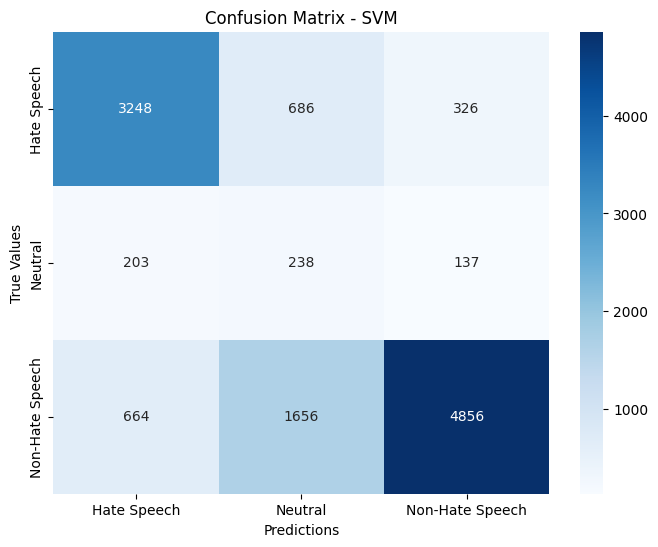

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

# تحميل البيانات
data = pd.read_csv("/content/sample_data/CompanyReviews.csv")

# تنظيف النصوص
arabic_stopwords = set(stopwords.words('arabic')) - {'لا'}

def clean_text(text):
    text = re.sub(r'[\u064B-\u0652]', '', text)  # إزالة التشكيل
    text = re.sub(r'(\d+:\d+|\d+)', r' \1 ', text)
    text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = text.strip().split()
    tokens = [word for word in tokens if word not in arabic_stopwords]
    return ' '.join(tokens)

data['cleaned_review'] = data['review_description'].fillna('').apply(clean_text)
data = data[data['rating'].isin([0, 1, -1])]
X = data['cleaned_review']
y = data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# توزيع الفئات قبل التوازن
plt.figure(figsize=(5, 3))
sns.countplot(x=y_train, order=sorted(y_train.unique()))
plt.title("Distribution Before Resampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# توزيع الفئات بعد التوازن (مرة واحدة فقط)
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X_train)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vect, y_train)

plt.figure(figsize=(5, 3))
sns.countplot(x=y_resampled, order=sorted(y_resampled.unique()))
plt.title("Distribution After Resampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# النماذج المستخدمة
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "SVM": SVC()
}

# معاملات التهيئة
param_grids = {
    "Logistic Regression": {
        'tfidf__ngram_range': [(1,1), (1,2)],
        'tfidf__max_features': [5000, 10000],
        'classifier__C': [0.1, 1, 10]
    },
    "Decision Tree": {
        'tfidf__ngram_range': [(1,1), (1,2)],
        'tfidf__max_features': [5000, 10000],
        'classifier__max_depth': [None, 10, 20]
    },
    "KNN": {
        'tfidf__ngram_range': [(1,1), (1,2)],
        'tfidf__max_features': [5000, 10000],
        'classifier__n_neighbors': [3, 5, 7]
    },
    "Random Forest": {
        'tfidf__ngram_range': [(1,1), (1,2)],
        'tfidf__max_features': [5000, 10000],
        'classifier__n_estimators': [100],
        'classifier__max_depth': [None, 10]
    },
    "SVM": {
        'tfidf__ngram_range': [(1,1)],
        'tfidf__max_features': [5000],
        'classifier__C': [1],
        'classifier__kernel': ['linear']
    }
}

# تدريب وتقييم النماذج
for name, model in models.items():
    print("="*30)
    print(f"Running model: {name}")
    print("="*30)

    pipeline = imbpipeline([
        ('tfidf', TfidfVectorizer()),
        ('oversample', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Best Parameters:", grid.best_params_)

    # مصفوفة الالتباس
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Hate Speech', 'Neutral', 'Non-Hate Speech'],
                yticklabels=['Hate Speech', 'Neutral', 'Non-Hate Speech'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.show()
    print()
